In [1]:
%load_ext lab_black

In [2]:
import os
import itertools
from multiprocessing.pool import ThreadPool

import numpy as np
import ee
import pandas as pd
import tqdm
import folium
from tqdm.contrib.concurrent import process_map
from sklearn.pipeline import Pipeline
from sklearn.model_selection import (
    train_test_split,`
    KFold,
    cross_val_score,
    GridSearchCV,
    RandomizedSearchCV,
)
from sklearn.preprocessing import (
    OneHotEncoder,
    LabelEncoder,
    PolynomialFeatures,
    StandardScaler,
)
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.impute import SimpleImputer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from lightgbm import LGBMClassifier

In [ ]:
ee.Authenticate()

In [3]:
ee.Initialize()

In [4]:
path = os.path.join("/home", "augusto", "Github", "DesafioAgTech2020")
os.chdir(path)

In [5]:
etiquetas = pd.read_csv(path + "/dataset/Etiquetas.csv")
train = pd.read_csv(path + "/dataset/data_train.csv")
test = pd.read_csv(path + "/dataset/data_test.csv")

In [6]:
train = pd.merge(train, etiquetas, on="Cultivo")
train["Tipo"] = train["Tipo"].apply(
    lambda x: x.replace(" ", "_").replace(",", "").lower()
)

In [7]:
def split_years(campania):
    start_year, end_year = tuple(campania.split("/"))
    return "20" + start_year, "20" + end_year

In [8]:
train["start_year"], train["end_year"] = zip(*train["Campania"].map(split_years))
test["start_year"], test["end_year"] = zip(*test["Campania"].map(split_years))

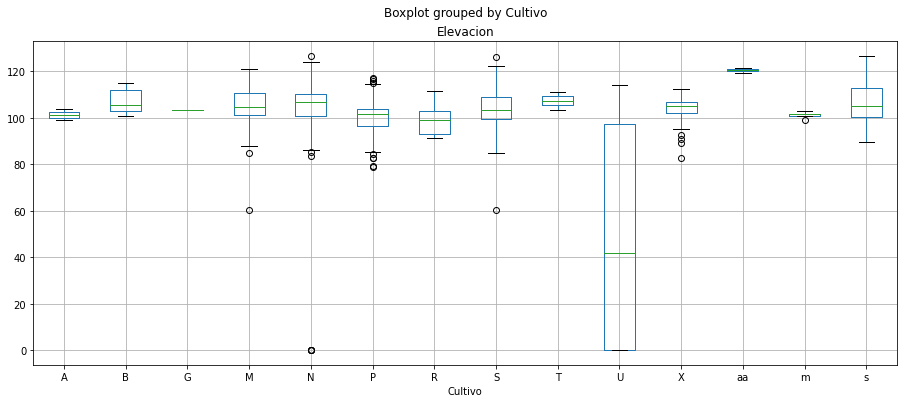

In [13]:
train.boxplot(column=["Elevacion"], by="Cultivo", figsize=(15, 6))

Eliminamos las observaciones con etiqueta "no_sabe" dado que no aportan ningun tipo de informacion

In [67]:
train_filtered = train.query("Tipo not in ('girasol')")

X_train, X_valid, y_train, y_valid = train_test_split(
    train_filtered.drop("Tipo", axis=1),
    train_filtered["Tipo"],
    stratify=train_filtered["Tipo"],
    test_size=0.5,
)

train_dataset = X_train.copy()
train_dataset["Tipo"] = y_train
train_dataset.reset_index(drop=True, inplace=True)
valid_dataset = X_valid.copy()
valid_dataset["Tipo"] = y_valid
valid_dataset.reset_index(drop=True, inplace=True)

train_dataset.loc[len(train_dataset) + 1] = train.query("Tipo == 'girasol'").iloc[
    0
]  # Agrego girasol


X_train, X_valid, y_train, y_valid = train_test_split(
    train_filtered.drop("Tipo", axis=1),
    train_filtered["Tipo"],
    stratify=train_filtered["Tipo"],
    test_size=0.5,
)

train_dataset = X_train.copy()
train_dataset["Tipo"] = y_train
train_dataset.reset_index(drop=True, inplace=True)
valid_dataset = X_valid.copy()
valid_dataset["Tipo"] = y_valid
valid_dataset.reset_index(drop=True, inplace=True)

train_dataset.loc[len(train_dataset) + 1] = train.query("Tipo == 'girasol'").iloc[
    0
]  # Agrego girasol

In [9]:
def get_coord_bands(long, lat, start_year, end_year, scale=10):
    generate_request = (
        ee.ImageCollection("COPERNICUS/S2_SR")
        .filterBounds(ee.Geometry.Point(long, lat))
        .filterDate(f"{start_year}-11-01", f"{end_year}-04-01")
        .filterMetadata("CLOUDY_PIXEL_PERCENTAGE", "less_than", 10)
        .reduce(ee.Reducer.mean())
        .reduceRegion(ee.Reducer.mean(), ee.Geometry.Point(long, lat), scale=scale)
    )
    pixel_bands = generate_request.getInfo()
    return pixel_bands

In [10]:
def get_coord_bands(long, lat, start_year, end_year, scale=10):
    generate_request = (
        ee.ImageCollection("COPERNICUS/S2_SR")
        .filterBounds(ee.Geometry.Point(long, lat))
        .filterDate(f"{start_year}-12-01", f"{end_year}-04-01")
        .filterMetadata("CLOUDY_PIXEL_PERCENTAGE", "less_than", 10)
        .reduce(ee.Reducer.mean())
        .reduceRegion(ee.Reducer.mean(), ee.Geometry.Point(long, lat), scale=scale)
    )
    pixel_bands = generate_request.getInfo()
    return pixel_bands

In [11]:
def get_coord_bands(long, lat, start_year, end_year, scale=10):
    generate_request = (
        ee.ImageCollection("COPERNICUS/S2_SR")
        .filterBounds(ee.Geometry.Point(long, lat))
        .filterDate(f"{start_year}-12-01", f"{end_year}-03-01")
        .filterMetadata("CLOUDY_PIXEL_PERCENTAGE", "less_than", 10)
        .reduce(ee.Reducer.mean())
        .reduceRegion(ee.Reducer.mean(), ee.Geometry.Point(long, lat), scale=scale)
    )
    pixel_bands = generate_request.getInfo()
    return pixel_bands

In [12]:
def get_coord_bands(long, lat, start_year, end_year, scale=10):
    generate_request = (
        ee.ImageCollection("COPERNICUS/S2_SR")
        .filterBounds(ee.Geometry.Point(long, lat))
        .filterDate(f"{start_year}-12-15", f"{end_year}-03-15")
        .filterMetadata("CLOUDY_PIXEL_PERCENTAGE", "less_than", 10)
        .reduce(ee.Reducer.mean())
        .reduceRegion(ee.Reducer.mean(), ee.Geometry.Point(long, lat), scale=scale)
    )
    pixel_bands = generate_request.getInfo()
    return pixel_bands

In [13]:
def get_bands_info(row):
    latitud = row["Latitud"]
    longitud = row["Longitud"]
    bands = get_coord_bands(
        long=longitud,
        lat=latitud,
        start_year=row["start_year"],
        end_year=row["end_year"],
    )
    data = {
        "latitud": latitud,
        "longitud": longitud,
        "elevacion": row["Elevacion"],
        "cultivo": row["CultivoId"],
        "etiqueta": row["Tipo"],
        **bands,
    }
    return data

In [14]:
def data_augmentation(row, start=-0.0005, end=0.0005, offset=0.0001):
    new_obs = []
    for lat_offset in np.arange(start, end, offset):
        for long_offset in np.arange(start, end, offset):
            image_type = (
                "original" if (long_offset == 0 and lat_offset == 0) else "augmented"
            )
            latitud = row["Latitud"] + lat_offset
            longitud = row["Longitud"] + long_offset
            for i in range(0, 100):
                try:
                    bands = get_coord_bands(
                        long=longitud,
                        lat=latitud,
                        start_year=row["start_year"],
                        end_year=row["end_year"],
                    )
                    break
                except Exception as e:
                    print(f"Retry {i}: {e}")
                    continue
            data = {
                "latitud": latitud,
                "longitud": longitud,
                "elevacion": row["Elevacion"],
                **bands,
                "cultivo": row["CultivoId"],
                "etiqueta": row["Tipo"],
                "imagen": image_type,
            }
            new_obs.append(data)
    return new_obs

In [48]:
train_augmented = pd.read_csv("train_v4_augmented.csv")
sep = pd.merge(
    train_augmented.rename(columns={"latitud": "Latitud", "longitud": "Longitud"}),
    train,
    on=["Latitud", "Longitud"],
    how="right",
)

valid_dataset = sep[sep["AOT_mean"].isna()].dropna(axis=1)

In [229]:
train_augmented = pd.read_csv("train_v4_augmented.csv")
sep = pd.merge(
    train_augmented.rename(columns={"latitud": "Latitud", "longitud": "Longitud"}),
    train,
    on=["Latitud", "Longitud"],
    how="right",
)

In [235]:
train.head()

,Id,Cultivo,Longitud,Latitud,Elevacion,Dataset,Campania,GlobalId,CultivoId,Tipo,start_year,end_year
0,1,S,-62.144163,-33.800202,104.111862,BC,18/19,1,1,soja_1,2018,2019
1,14,S,-62.131195,-33.789271,103.085487,BC,18/19,14,1,soja_1,2018,2019
2,15,S,-62.140227,-33.797085,101.863167,BC,18/19,15,1,soja_1,2018,2019
3,23,S,-62.207429,-33.844643,115.140739,BC,18/19,23,1,soja_1,2018,2019
4,33,S,-62.052854,-33.754545,102.544304,BC,18/19,33,1,soja_1,2018,2019


In [231]:
valid_dataset.shape

(462, 12)

In [239]:
train_augmented.head()

,latitud,longitud,elevacion,AOT_mean,B11_mean,B12_mean,B1_mean,B2_mean,B3_mean,B4_mean,...,QA20_mean,QA60_mean,SCL_mean,TCI_B_mean,TCI_G_mean,TCI_R_mean,WVP_mean,cultivo,etiqueta,imagen
0,-34.270263,-62.031311,113.319977,189.428571,1998.142857,1146.714286,320.714286,355.285714,665.142857,617.285714,...,0,292.571429,4.857143,36.857143,68.000000,63.000000,1676.571429,10,campo_natural,augmented
1,-34.270263,-62.031211,113.319977,189.285714,2769.714286,1713.000000,320.714286,459.142857,765.714286,828.571429,...,0,292.571429,5.142857,47.142857,78.428571,85.000000,1629.285714,10,campo_natural,augmented
2,-34.270263,-62.031111,113.319977,189.285714,2769.714286,1713.000000,320.714286,459.142857,765.714286,828.571429,...,0,292.571429,5.142857,47.142857,78.428571,85.000000,1629.285714,10,campo_natural,augmented
3,-34.270263,-62.031011,113.319977,189.285714,2769.714286,1713.000000,320.714286,523.142857,867.428571,955.000000,...,0,292.571429,5.142857,53.428571,89.000000,98.000000,1629.285714,10,campo_natural,augmented
4,-34.270263,-62.030911,113.319977,189.285714,3077.714286,1980.428571,358.857143,604.142857,941.571429,1086.285714,...,0,292.571429,5.285714,62.000000,96.285714,110.571429,1591.857143,10,campo_natural,augmented


In [237]:
sep[sep["AOT_mean"].isna()]

,Latitud,Longitud,elevacion,AOT_mean,B11_mean,B12_mean,B1_mean,B2_mean,B3_mean,B4_mean,...,Id,Cultivo,Elevacion,Dataset,Campania,GlobalId,CultivoId,Tipo,start_year,end_year
387,-33.800202,-62.144163,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1,S,104.111862,BC,18/19,1,1,soja_1,2018,2019
388,-33.789271,-62.131195,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,14,S,103.085487,BC,18/19,14,1,soja_1,2018,2019
389,-33.754545,-62.052854,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,33,S,102.544304,BC,18/19,33,1,soja_1,2018,2019
390,-33.870758,-62.146479,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,57,S,113.059998,BC,18/19,57,1,soja_1,2018,2019
391,-33.847989,-62.208587,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,89,S,110.176811,BC,18/19,89,1,soja_1,2018,2019
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
844,-33.791834,-61.210180,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,466,U,-0.000023,BCR,19/20,1448,24,urbano,2019,2020
845,-33.931952,-62.100384,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,249,B,107.368271,BC,19/20,799,11,barbecho,2019,2020
846,-33.651820,-62.302571,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,270,B,114.898140,BC,19/20,820,11,barbecho,2019,2020
847,-33.812640,-61.873674,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,323,B,103.934578,BC,19/20,873,11,barbecho,2019,2020


In [ ]:
valid_dataset = sep[sep["AOT_mean"].isna()].dropna(axis=1)

In [230]:
sep

,Latitud,Longitud,elevacion,AOT_mean,B11_mean,B12_mean,B1_mean,B2_mean,B3_mean,B4_mean,...,Id,Cultivo,Elevacion,Dataset,Campania,GlobalId,CultivoId,Tipo,start_year,end_year
0,-34.269763,-62.030811,113.319977,189.428571,2595.428571,1551.857143,363.285714,445.714286,805.857143,818.857143,...,313,N,113.319977,BCR,19/20,1295,10,campo_natural,2019,2020
1,-33.872757,-62.084742,105.427490,186.500000,1839.166667,890.166667,81.000000,213.500000,563.500000,307.833333,...,143,M,105.427490,BC,18/19,143,3,maiz_temp,2018,2019
2,-33.808925,-61.906541,101.965805,166.800000,2739.800000,1607.733333,336.533333,455.533333,760.000000,703.466667,...,314,S,101.965805,BC,19/20,864,1,soja_1,2019,2020
3,-33.702580,-61.617410,96.019977,153.500000,3104.875000,2538.250000,967.500000,1169.250000,1395.000000,1490.500000,...,436,U,96.019977,BCR,19/20,1418,24,urbano,2019,2020
4,-33.868182,-62.172699,104.783669,167.117647,2790.764706,1850.823529,406.764706,607.941176,993.058824,1083.588235,...,127,P,104.783669,BC,19/20,677,9,forrajes_pasturas_verdeos,2019,2020
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
844,-33.791834,-61.210180,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,466,U,-0.000023,BCR,19/20,1448,24,urbano,2019,2020
845,-33.931952,-62.100384,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,249,B,107.368271,BC,19/20,799,11,barbecho,2019,2020
846,-33.651820,-62.302571,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,270,B,114.898140,BC,19/20,820,11,barbecho,2019,2020
847,-33.812640,-61.873674,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,323,B,103.934578,BC,19/20,873,11,barbecho,2019,2020


In [18]:
thread_pool = ThreadPool(8)
info = train.to_dict(orient="records")
data_temp = thread_pool.map(get_bands_info, info)

In [30]:
data_temp_2 = thread_pool.map(get_bands_info, info)

In [37]:
data_temp_3 = thread_pool.map(get_bands_info, info)

In [47]:
data_temp_4 = thread_pool.map(get_bands_info, info)

In [56]:
data_temp_5 = thread_pool.map(get_bands_info, info)

In [57]:
data_df = pd.DataFrame(data_temp_5)

In [88]:
thread_pool = ThreadPool(8)
info = train_dataset.to_dict(orient="records")
data = thread_pool.map(data_augmentation, info)

In [93]:
train_augmented = pd.DataFrame(list(itertools.chain.from_iterable(data)))
train_augmented.to_csv("train_v4_augmented.csv", index=False)

In [50]:
thread_pool = ThreadPool(8)

In [ ]:
valid_info = valid_dataset.to_dict(orient="records")
data_valid = thread_pool.map(data_augmentation, valid_info)
valid_augmented = pd.DataFrame(list(itertools.chain.from_iterable(data_valid)))
valid_augmented.to_csv("valid_v3_augmented.csv", index=False)

In [ ]:
train_augmented.boxplot([col for col in train_augmented if col.startswith('B')], by="etiqueta", figsize=(15,6));

In [53]:
def process_features(dataset, label=None):
    df = dataset.copy()
    df["NDVI_mean"] = (df["B8_mean"] - df["B4_mean"]) / (df["B8_mean"] + df["B4_mean"])
    df["GNDVI_mean"] = (df["B8_mean"] - df["B3_mean"]) / (df["B8_mean"] + df["B3_mean"])
    df["SAVI_mean"] = (
        (df["B8_mean"] - df["B4_mean"])
        / (df["B8_mean"] + df["B4_mean"] + 0.428)
        * (1.428)
    )
    df["NDMI_mean"] = (df["B8_mean"] - df["B11_mean"]) / (
        df["B8_mean"] + df["B11_mean"]
    )
    df["MSI_mean"] = df["B11_mean"] / df["B8_mean"]
    df["GCI_mean"] = (df["B9_mean"] / df["B3_mean"]) - 1
    df["BSI_mean"] = (
        (df["B11_mean"] + df["B4_mean"]) - (df["B8_mean"] + df["B2_mean"])
    ) / ((df["B11_mean"] + df["B4_mean"]) + (df["B8_mean"] + df["B2_mean"]))
    for value in np.arange(0, 1.0, 0.4):
        df[f"NDVI_mean<{value}"] = np.where(df["NDVI_mean"] < value, 1, 0)
    X_cols = [col for col in df if col.endswith("mean")] + ["elevacion"]
    X = df[X_cols]
    y = np.array(df[label]) if label else None
    return X, y

In [ ]:
def is_outlier(s):
    lower_limit = s.mean() - (s.std() * 1.2)
    upper_limit = s.mean() + (s.std() * 1.2)
    return ~s.between(lower_limit, upper_limit)

In [244]:
train_augmented = pd.read_csv("train_v4_augmented.csv")
valid_augmented = pd.read_csv("valid_v4_augmented.csv")

In [221]:
train_augmented = train_augmented.query("cultivo != 23")
valid_augmented = valid_augmented.query("cultivo != 23")

In [247]:
train_augmented["cultivo"].value_counts()

1     17200
3     10500
2      4400
10     4100
9      2800
23     1700
24      600
11      300
8       300
4       200
19      100
15      100
7       100
5       100
Name: cultivo, dtype: int64

In [246]:
valid_augmented["cultivo"].value_counts()

1     18500
3     11700
2      5200
10     4400
9      2800
23     1800
24      600
8       400
11      300
4       200
19      100
15      100
5       100
Name: cultivo, dtype: int64

In [248]:
train_augmented.drop(
    ["MSK_SNWPRB_mean", "QA10_mean", "QA20_mean"], axis=1, inplace=True
)
valid_augmented.drop(
    ["MSK_SNWPRB_mean", "QA10_mean", "QA20_mean"], axis=1, inplace=True
)

In [249]:
X_train_augmented, y_train_augmented = process_features(
    train_augmented, label="cultivo"
)

In [250]:
X_valid_augmented, y_valid_augmented = process_features(
    valid_augmented, label="cultivo"
)

In [157]:
new_df = X_train_augmented.copy()
new_df["cultivo"] = y_train_augmented
train_no_outliers = new_df[~new_df.groupby("cultivo")["NDVI_mean"].apply(is_outlier)]
train_no_outliers = train_no_outliers.query("cultivo != 23")

new_df = X_valid_augmented.copy()
new_df["cultivo"] = y_valid_augmented
#valid_no_outliers = new_df[~new_df.groupby("cultivo")["NDVI_mean"].apply(is_outlier)]
valid_no_outliers = valid_no_outliers.query("cultivo != 23")

X_train_augmented, y_train_augmented = process_features(
    train_no_outliers, label="cultivo"
)

X_valid_augmented, y_valid_augmented = process_features(
    valid_no_outliers, label="cultivo"
)

In [ ]:
fechas_cosecha = {
    "alfalfa": ("%s-09-01", "%s-12-31"),
    "sorgo": ("%s-02-01", "%s-03-31"),
    "maiz_temp": ("%s-01-01", "%s-01-31"),
    "maiz_tard_o_2da": ("%s-01-15", "%s-02-15"),
    "soja_1": ("%s-01-01", "%s-02-28"),
    "girasol": ("%s-01-01", "%s-02-28"),
    "soja_2": ("%s-02-01", "%s-03-31"),
    "trigo": ("%s-01-01", "%s-02-28"),
    "barbecho": ("%s-04-01", "%s-05-30"),
    "campo_natural": ("%s-04-01", "%s-05-30"),
    "forrajes_pasturas_verdeos": ("%s-04-01", "%s-05-30"),
    "urbano": ("%s-07-01", "%s-08-31"),
    "no_sabe": ("%s-07-01", "%s-08-31"),
    "agua": ("%s-07-01", "%s-08-31"),
}

In [43]:
data_df["cultivo"].value_counts()

soja_1                       344
maiz_temp                    210
soja_2                        89
campo_natural                 82
forrajes_pasturas_verdeos     55
no_sabe                       34
urbano                        12
barbecho                       6
sorgo                          6
maiz_tard_o_2da                4
trigo                          2
agua                           2
alfalfa                        2
girasol                        1
Name: cultivo, dtype: int64

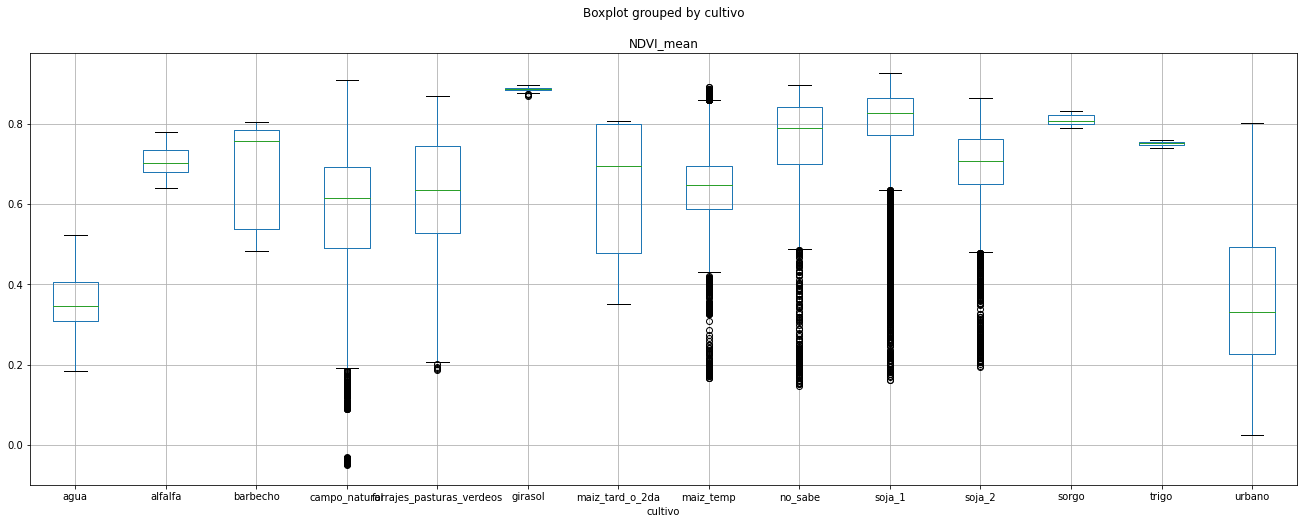

In [105]:
X_train_augmented["cultivo"] = train_augmented["etiqueta"]
X_train_augmented.boxplot("NDVI_mean", by="cultivo", figsize=(22, 8))

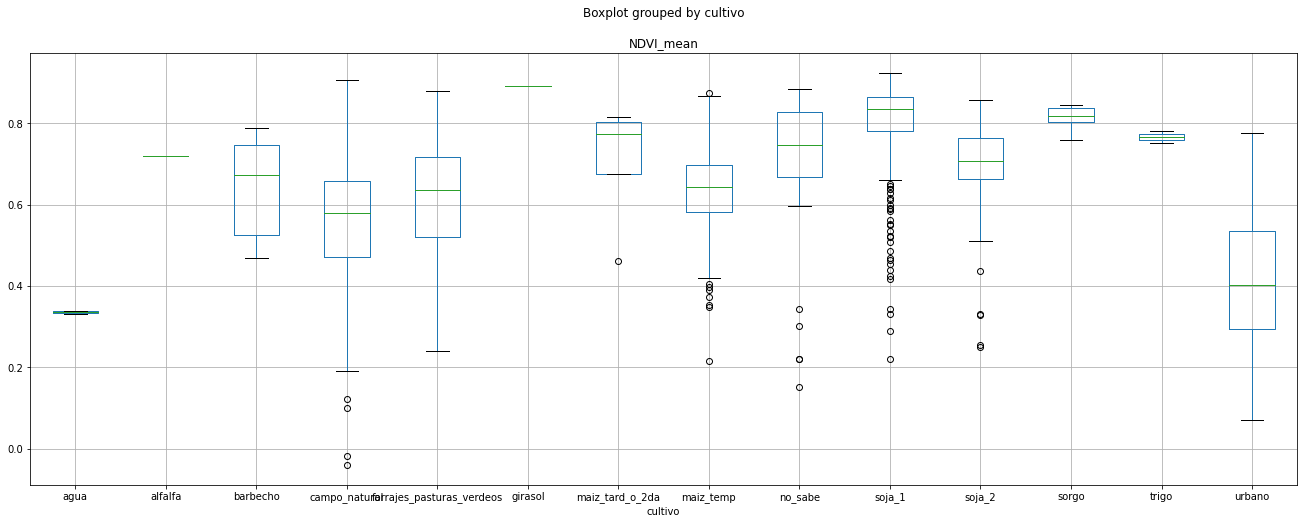

In [60]:
X_train_augmented.boxplot("NDVI_mean", by="cultivo", figsize=(22, 8))

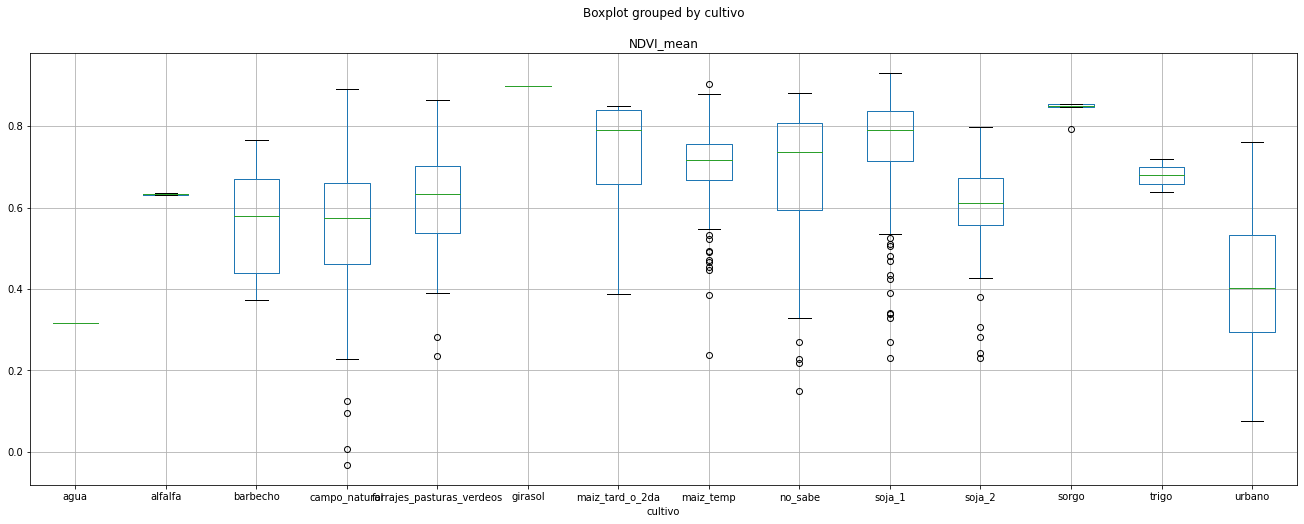

In [51]:
X_train_augmented.boxplot("NDVI_mean", by="cultivo", figsize=(22, 8))

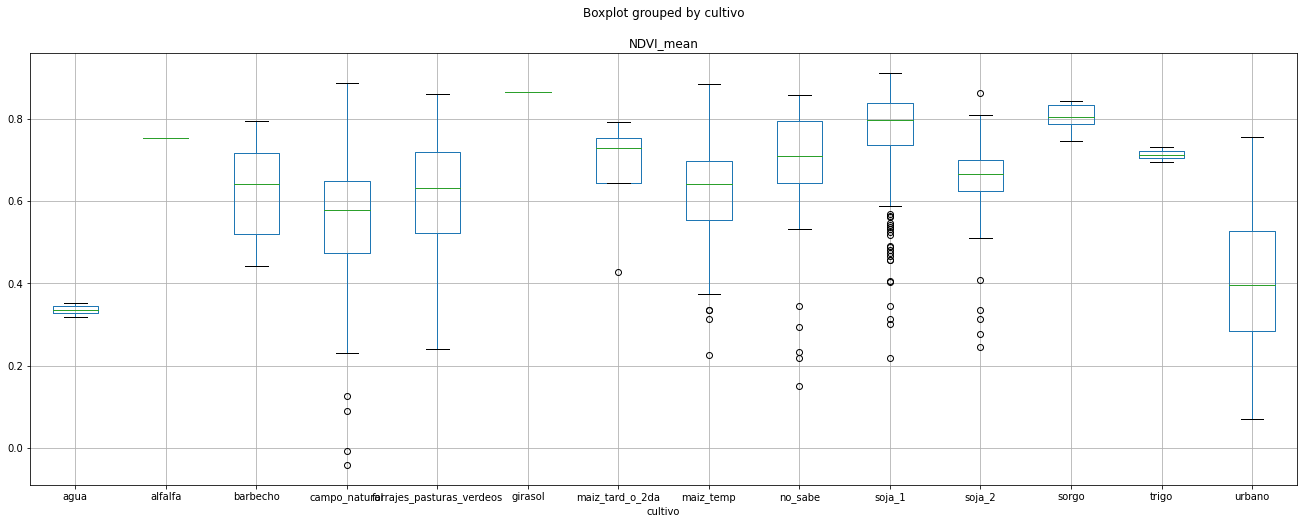

In [34]:
X_train_augmented.boxplot("NDVI_mean", by="cultivo", figsize=(22, 8))

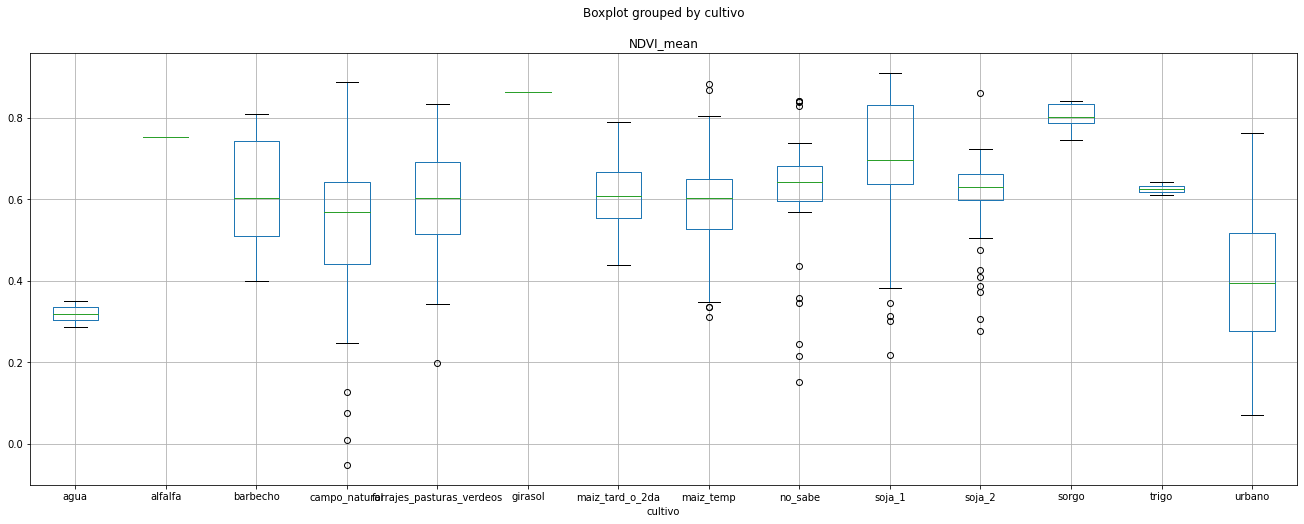

In [26]:
X_train_augmented.boxplot("NDVI_mean", by="cultivo", figsize=(22, 8))

## **SKLEARM**

In [105]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from imblearn.pipeline import Pipeline as imPipeline
from imblearn.over_sampling import SMOTE

In [295]:
from sklearn.metrics import balanced_accuracy_score

In [310]:
1 / 14

0.07142857142857142

In [303]:
balanced_accuracy_score([1, 2, 3, 4, 5, 6, 7], [1, 1, 1, 1, 1, 1, 1])

0.14285714285714285

In [190]:
sbalanced_accuracy_score ("estimator", RandomForestClassifier(n_jobs=-1)),
]
pipe = Pipeline(steps=steps)
pipe.fit(X_train_augmented, y_train_augmented)

Pipeline(steps=[('estimator', RandomForestClassifier(n_jobs=-1))])

In [191]:
print(classification_report(y_valid_augmented, pipe.predict(X_valid_augmented)))

              precision    recall  f1-score   support

           1       0.98      1.00      0.99      9417
           2       0.94      0.96      0.95      2319
           3       0.95      0.94      0.94      4503
           4       0.00      0.00      0.00       105
           5       0.00      0.00      0.00        45
           8       0.00      0.00      0.00       194
           9       0.69      0.72      0.70      1171
          10       0.72      0.80      0.76      1985
          11       0.00      0.00      0.00       125
          15       0.98      1.00      0.99        40
          19       1.00      1.00      1.00        37
          24       0.93      0.42      0.58       238

    accuracy                           0.92     20179
   macro avg       0.60      0.57      0.58     20179
weighted avg       0.90      0.92      0.91     20179



In [108]:
preds = pipe.predict(X_valid_augmented)

In [111]:
pd.Series(preds).value_counts()

1     20522
3     10056
10     5979
2      4106
9      3573
23      820
24      622
15      266
8        97
19       96
11       37
4        20
5         6
dtype: int64

In [ ]:
# Generamos las etiquetas predichas por nuestra red
y_pred = pipe.predict(X_valid_augmented)
test_pred = encoder.inverse_transform(np.argmax(y_pred, axis=1))
test_labels_ = y_valid_augmented

# Confusion Matrix
fig, ax = plt.subplots(figsize=(10, 10))
conf_matrix = confusion_matrix(test_labels_, test_pred)
conf_matrix = conf_matrix / np.sum(conf_matrix, axis=1)

sns.heatmap(
    conf_matrix, annot=True, fmt=".2f", square=True, cbar=False, cmap=plt.cm.jet, ax=ax
)
ax.set_ylabel("Actual")
ax.set_xlabel("Predicted")
ax.set_title("Confusion Matrix")
plt.show()

print("Classification Report:")
print(classification_report(test_labels_, test_pred))

In [192]:
test_final = pd.read_csv("test_data_v4.csv")
X_final, _ = process_features(test_final)
X_final = X_final.drop(["MSK_SNWPRB_mean", "QA10_mean", "QA20_mean"], axis=1)

In [193]:
preds = pipe.predict(X_final)

In [200]:
qq = test.copy()
qq["preds"] = preds

In [204]:
pd.Series(preds).value_counts()

1     181
10     95
2      84
3      60
9      54
7      34
11     23
24     12
15      8
4       3
5       1
dtype: int64

In [231]:
qq[["GlobalId", "preds"]].to_csv(
    "preds_sadosky_nn_point_data_mean_SMOTE_test_RF.csv", header=None, index=False
)

In [ ]:
qq = test.copy()
qq["preds"] = encoder.inverse_transform(np.argmax(preds, axis=1))

qq[["GlobalId", "preds"]].to_csv(
    "preds_sadosky_nn_point_data_mean_SMOTE_test_v1.csv", header=None, index=False
)

## **NN**

In [116]:
import tensorflow
import keras
from keras.models import Sequential
from keras.layers import (
    Dense,
    Activation,
    Conv1D,
    MaxPooling1D,
    Flatten,
    Dropout,
    BatchNormalization,
)
from keras import regularizers, initializers

In [ ]:
from pandas_profiling import ProfileReport
report = ProfileReport(X_train_augmented, title="Revision Features", minimal=True)
report.to_notebook_iframe();

Always standardize AFTER generating PolynomialFeatures. 1.) Loss of signal. When you create feature interactions, you're generating values that are multiples and squares of themselves.

In [257]:
sc_X = StandardScaler()
X_encoded_train = sc_X.fit_transform(X_train_augmented)
X_encoded_valid = sc_X.transform(X_valid_augmented)

oversample = SMOTE()
X_train_balanced, y_train_balanced = oversample.fit_resample(
    X_encoded_train, y_train_augmented
)

# encode class values as integers
encoder = LabelEncoder()
encoded_Y_train = encoder.fit_transform(y_train_augmented)
encoded_Y_train_balanced = encoder.fit_transform(y_train_balanced)
encoded_Y_valid = encoder.transform(y_valid_augmented)
# convert integers to dummy variables (i.e. one hot encoded)
dummy_y_train = keras.utils.to_categorical(encoded_Y_train)
dummy_y_train_balanced = keras.utils.to_categorical(encoded_Y_train_balanced)
dummy_y_valid = keras.utils.to_categorical(encoded_Y_valid)

In [ ]:
sc_X = StandardScaler()
poly_feats = PolynomialFeatures(degree=2)

X_train_poly = poly_feats.fit_transform(X_train_augmented)
X_valid_poly = poly_feats.transform(X_valid_augmented)

X_encoded_train_poly = sc_X.fit_transform(X_train_poly)
X_encoded_valid_poly = sc_X.transform(X_valid_poly)

oversample = SMOTE()
X_train_balanced, y_train_balanced = oversample.fit_resample(
    X_encoded_train_poly, y_train_augmented
)

# encode class values as integers
encoder = LabelEncoder()
encoded_Y_train = encoder.fit_transform(y_train_augmented)
encoded_Y_train_balanced = encoder.fit_transform(y_train_balanced)
encoded_Y_valid = encoder.transform(y_valid_augmented)
# convert integers to dummy variables (i.e. one hot encoded)
dummy_y_train = keras.utils.to_categorical(encoded_Y_train)
dummy_y_train_balanced = keras.utils.to_categorical(encoded_Y_train_balanced)
dummy_y_valid = keras.utils.to_categorical(encoded_Y_valid)

In [258]:
n_classes = dummy_y_train.shape[1]

In [259]:
n_classes

14

In [260]:
from keras import backend as K


def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall


def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision


def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2 * ((precision * recall) / (precision + recall + K.epsilon()))

In [261]:
model = Sequential()
model.add(
    Dense(
        128,
        activation="relu",
        kernel_regularizer=regularizers.l2(1e-5),
        bias_initializer="zeros",
    )
)
model.add(Dropout(0.5))
model.add(Dense(n_classes, activation="softmax"))
model.compile(
    loss="categorical_crossentropy",
    optimizer=keras.optimizers.Adam(lr=0.001),
    metrics=["accuracy", recall_m, precision_m, f1_m],
)

model.fit(
    X_train_balanced,
    dummy_y_train_balanced,
    epochs=3,
    validation_data=(X_encoded_valid, dummy_y_valid),
)

Epoch 1/3
7525/7525 [==============================] - 9s 1ms/step - loss: 0.5530 - accuracy: 0.8160 - recall_m: 0.7315 - precision_m: 0.9018 - f1_m: 0.8001 - val_loss: 1.3229 - val_accuracy: 0.6537 - val_recall_m: 0.5804 - val_precision_m: 0.6467 - val_f1_m: 0.6010
Epoch 2/3
7525/7525 [==============================] - 9s 1ms/step - loss: 0.3413 - accuracy: 0.8834 - recall_m: 0.8470 - precision_m: 0.9195 - f1_m: 0.8811 - val_loss: 1.4997 - val_accuracy: 0.6947 - val_recall_m: 0.6427 - val_precision_m: 0.6960 - val_f1_m: 0.6592
Epoch 3/3
7525/7525 [==============================] - 9s 1ms/step - loss: 0.2932 - accuracy: 0.9005 - recall_m: 0.8741 - precision_m: 0.9265 - f1_m: 0.8991 - val_loss: 1.6692 - val_accuracy: 0.6958 - val_recall_m: 0.6612 - val_precision_m: 0.7083 - val_f1_m: 0.6762


In [163]:
model.fit(
    X_train_balanced,
    dummy_y_train_balanced,
    epochs=1,
    validation_data=(X_encoded_valid, dummy_y_valid),
)

3638/3638 [==============================] - 5s 1ms/step - loss: 0.0665 - accuracy: 0.9794 - recall_m: 0.9776 - precision_m: 0.9814 - f1_m: 0.9794 - val_loss: 0.7863 - val_accuracy: 0.8972 - val_recall_m: 0.8957 - val_precision_m: 0.8975 - val_f1_m: 0.8966


/home/augusto/.python_venvs/local/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in true_divide
  
/home/augusto/.python_venvs/local/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  
/home/augusto/.python_venvs/local/lib/python3.6/site-packages/matplotlib/colors.py:1026: RuntimeWarning: invalid value encountered in true_divide
  resdat /= (vmax - vmin)


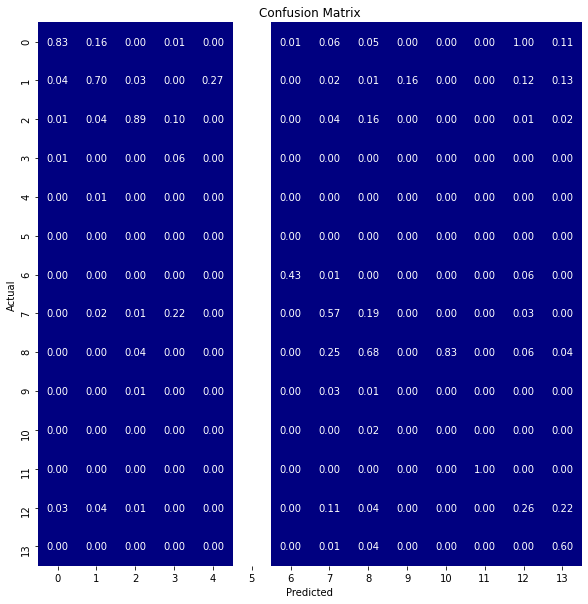

Classification Report:
              precision    recall  f1-score   support

           1       0.90      0.83      0.86     16412
           2       0.72      0.70      0.71      4270
           3       0.90      0.89      0.89      8779
           4       0.17      0.06      0.09       189
           5       0.00      0.00      0.00        81
           7       0.00      0.00      0.00         0
           8       0.98      0.43      0.59       304
           9       0.52      0.57      0.54      2221
          10       0.57      0.68      0.62      3560
          11       0.00      0.00      0.00       236
          15       0.00      0.00      0.00        78
          19       1.00      1.00      1.00        75
          23       0.17      0.26      0.20      1605
          24       0.53      0.60      0.57       435

    accuracy                           0.76     38245
   macro avg       0.46      0.43      0.43     38245
weighted avg       0.78      0.76      0.77     38245



/home/augusto/.python_venvs/local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [125]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Generamos las etiquetas predichas por nuestra red
y_pred = model.predict(X_encoded_valid)
test_pred = encoder.inverse_transform(np.argmax(y_pred, axis=1))
test_labels_ = y_valid_augmented

# Confusion Matrix
fig, ax = plt.subplots(figsize=(10, 10))
conf_matrix = confusion_matrix(test_labels_, test_pred)
conf_matrix = conf_matrix / np.sum(conf_matrix, axis=1)

sns.heatmap(
    conf_matrix, annot=True, fmt=".2f", square=True, cbar=False, cmap=plt.cm.jet, ax=ax
)
ax.set_ylabel("Actual")
ax.set_xlabel("Predicted")
ax.set_title("Confusion Matrix")
plt.show()

print("Classification Report:")
print(classification_report(test_labels_, test_pred))

In [ ]:
full_df = train_augmented.append(valid_augmented, ignore_index=True)
full_x, full_y = process_features(full_df, label="cultivo")
sc_final = StandardScaler()
X_encoded_final = sc_final.fit_transform(full_x)

# encode class values as integers
encoder_final = LabelEncoder()
encoded_Y_final = encoder.fit_transform(full_y)
# convert integers to dummy variables (i.e. one hot encoded)
dummy_y_final = keras.utils.to_categorical(encoded_Y_final)

SMOTE

In [ ]:
train_augmented.drop(
    ["MSK_SNWPRB_mean", "QA10_mean", "QA20_mean"], axis=1, inplace=True
)
full_df.drop(
    ["MSK_SNWPRB_mean", "QA10_mean", "QA20_mean"], axis=1, inplace=True
)
new_df = X_train_augmented.copy()
new_df["cultivo"] = y_train_augmented
train_no_outliers = new_df[~new_df.groupby("cultivo")["NDVI_mean"].apply(is_outlier)]
train_no_outliers = train_no_outliers.query("cultivo != 23")

In [175]:
full_df = train_augmented.append(valid_augmented, ignore_index=True)
full_x, full_y = process_features(new_df, label="cultivo")
new_df = full_x.copy()
new_df["cultivo"] = full_y
full_x = new_df[~new_df.groupby("cultivo")["NDVI_mean"].apply(is_outlier)]
full_x = train_no_outliers.query("cultivo != 23")
full_x, full_y = process_features(full_x, label="cultivo")

In [283]:
full_df = train_augmented.append(valid_augmented, ignore_index=True)
full_x, full_y = process_features(full_df, label="cultivo")
sc_final = StandardScaler()
X_encoded_final = sc_final.fit_transform(full_x)

oversample = SMOTE()
X_final_balanced, y_final_balanced = oversample.fit_resample(X_encoded_final, full_y)

# encode class values as integers
encoder_final = LabelEncoder()
encoded_Y_final_balanced = encoder_final.fit_transform(y_final_balanced)
# convert integers to dummy variables (i.e. one hot encoded)
dummy_y_final_balanced = keras.utils.to_categorical(encoded_Y_final_balanced)

In [284]:
n_classes

14

In [285]:
model = Sequential()
model.add(
    Dense(
        128,
        activation="relu",
        kernel_regularizer=regularizers.l2(1e-5),
        bias_initializer="zeros",
    )
)
model.add(Dropout(0.5))
model.add(Dense(n_classes, activation="softmax"))
model.compile(
    loss="categorical_crossentropy",
    optimizer=keras.optimizers.Adam(lr=0.001),
    metrics=["accuracy", recall_m, precision_m, f1_m],
)

model.fit(
    X_final_balanced, dummy_y_final_balanced, epochs=2,
)

Epoch 1/2
15619/15619 [==============================] - 18s 1ms/step - loss: 0.5582 - accuracy: 0.8162 - recall_m: 0.7352 - precision_m: 0.8953 - f1_m: 0.8013
Epoch 2/2
15619/15619 [==============================] - 19s 1ms/step - loss: 0.3760 - accuracy: 0.8705 - recall_m: 0.8292 - precision_m: 0.9102 - f1_m: 0.8671


In [179]:
model.fit(
    X_final_balanced, dummy_y_final_balanced, epochs=1,
)

3638/3638 [==============================] - 4s 1ms/step - loss: 0.1099 - accuracy: 0.9648 - recall_m: 0.9584 - precision_m: 0.9713 - f1_m: 0.9647


In [ ]:
model.save("modelo_ganador.h5")

## **Final pipeline**

In [113]:
def get_bands_info(row):
    latitud = row["Latitud"]
    longitud = row["Longitud"]
    bands = get_coord_bands(
        long=longitud,
        lat=latitud,
        start_year=row["start_year"],
        end_year=row["end_year"],
    )
    data = {
        "latitud": latitud,
        "longitud": longitud,
        "elevacion": row["Elevacion"],
        **bands,
    }
    return data

In [120]:
thread_pool = ThreadPool(8)
test_bands = thread_pool.map(get_bands_info, test.to_dict(orient="records"))
test_final = pd.DataFrame(test_bands)
test_final.to_csv("test_data_v4.csv", index=False)

In [286]:
test_final = pd.read_csv("test_data_v4.csv")

In [287]:
X_final, _ = process_features(test_final)
X_final.drop(["MSK_SNWPRB_mean", "QA10_mean", "QA20_mean"], axis=1, inplace=True)

In [288]:
X_encoded_test = sc_final.transform(X_final)

In [289]:
preds = model.predict(X_encoded_test)

In [ ]:
pd.DataFrame(np.argmax(preds, axis=1))

preds.max(axis=1)

np.argwhere(preds > 0.01)

(preds.max(axis=1) < 0.4).mean()

preds.

plt.hist(preds.max(axis=1))

In [ ]:
import matplotlib.pyplot as plt

In [291]:
qq = test.copy()
qq["preds"] = encoder_final.inverse_transform(np.argmax(preds, axis=1))

In [293]:
qq[["GlobalId", "preds"]].to_csv(
    "preds_sadosky_nn_point_data_mean_SMOTE_test_v4.csv", header=None, index=False
)

In [140]:
train["CultivoId"].value_counts()

1     344
3     210
2      89
10     82
9      55
23     34
24     12
11      6
8       6
4       4
19      2
15      2
5       2
7       1
Name: CultivoId, dtype: int64

In [292]:
qq["preds"].value_counts()

1     210
3     143
2      72
9      49
10     42
23     22
24      8
15      2
11      2
8       2
7       1
5       1
4       1
Name: preds, dtype: int64

In [139]:
qq["preds"].value_counts()

1     172
3     146
2      79
23     50
9      50
10     45
24      6
15      2
11      2
8       2
4       1
Name: preds, dtype: int64

In [133]:
qq["preds"].value_counts()

1     177
3     138
2      77
9      56
10     46
23     45
24      7
15      2
11      2
8       2
4       2
7       1
Name: preds, dtype: int64

In [225]:
qq["preds"].value_counts()

1     195
3     141
2      62
10     53
9      50
23     43
24      6
11      2
7       2
8       1
Name: preds, dtype: int64

In [ ]:
qq["preds"].value_counts()

In [ ]:
qq["preds"].value_counts()

In [ ]:
qq["preds"].value_counts()

In [ ]:
qq["preds"].value_counts()

In [ ]:
qq["preds"].value_counts()

In [ ]:
qq["preds"].value_counts()

In [ ]:
train["CultivoId"].value_counts()

# **ENSAMBLEEEEEEEEE**

In [ ]:
from keras.models import load_model

In [ ]:
model_ganador = load_model("modelo_ganador.h5")

In [ ]:
new_full_df = pd.DataFrame(X_final_balanced, columns=X_train_augmented.columns)

In [ ]:
preds_X = model_ganador.predict(X_encoded_final)

In [ ]:
X_encoded_final

In [ ]:
new_full_df = pd.DataFrame(X_encoded_final, columns=X_train_augmented.columns)
new_full_df["preds"] = encoder.inverse_transform(np.argmax(preds_X, axis=1))

In [ ]:
clf = LGBMClassifier(n_jobs=-1)

clf.fit(new_full_df, full_y)

In [ ]:
svc_model = SVC()

svc_model.fit(new_full_df, full_y)

In [ ]:
feat_imp = pd.DataFrame(
    list(zip(new_full_df.columns, clf.feature_importances_,))
).rename(columns={0: "Feature", 1: "Importance"})
feat_imp.sort_values("Importance", ascending=False)[:20]

In [ ]:
new_test = X_encoded_test.copy()
new_test = pd.DataFrame(new_test, columns=X_train_augmented.columns)

In [ ]:
preds_text = model.predict(new_test)
new_test["preds"] = encoder.inverse_transform(np.argmax(preds_text, axis=1))

In [ ]:
new_test["preds"].value_counts()

In [ ]:
ensamble_preds = svc_model.predict(new_test)

In [ ]:
ensamble_preds

In [ ]:
ensamble_pred = test.copy()
ensamble_pred["preds"] = ensamble_preds

In [ ]:
qq["preds_2"].value_counts()

In [ ]:
ensamble_pred["preds"].value_counts()

In [ ]:
ensamble_pred["preds"].value_counts()

In [ ]:
ensamble_pred[["GlobalId", "preds"]].to_csv(
    "preds_sadosky_nn_point_data_mean_SMOTE_ensamble.csv", header=None, index=False
)